In [196]:
import pandas as pd
from src.data import gedi_pipeline
from src.constants import DATA_PATH, USER_PATH
import seaborn as sns
import geopandas as gpd

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.metrics import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
from src.processing.control import random_control
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from src.processing.control import random_control, eval, nearest, terrain_clustering
from src.data import k_nn
from src.data import clustering
import numpy as np
from src.data import shape_processor
from src.processing.rf import split_data

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)
importlib.reload(random_control)
importlib.reload(eval)
importlib.reload(terrain_clustering)
importlib.reload(k_nn)
importlib.reload(clustering)
importlib.reload(raster)

2023-06-13 12:12:05,161 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-13 12:12:05,164 DEBUG: Logger /home/jk871/fire-regen/src/data/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-13 12:12:05,167 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-13 12:12:05,170 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.raster' from '/home/jk871/fire-regen/src/data/raster.py'>

In [197]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras)

In [70]:
def r_mse(pred,y): return round(math.sqrt(mean_squared_error(y, pred)), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def r_squared(pred, y):
    return r2_score(y, pred)
def m_r2(m, xs, y): return r_squared(m.predict(xs), y)

In [74]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

In [75]:
seki = gpd.read_file(f"{USER_PATH}/data/shapefiles/seki_convex_hull.shp")

In [80]:
training = gpd.GeoDataFrame(geometry=sierras.difference(seki), crs=sierras.crs)

In [10]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_9(3)

In [44]:
landsat_1991 = raster.RasterSampler(raster.LANDSAT5_RASTER(1991), raster.LANDSAT5_BANDS)
landsat_1992 = raster.RasterSampler(raster.LANDSAT5_RASTER(1992), raster.LANDSAT5_BANDS)
landsat_1993 = raster.RasterSampler(raster.LANDSAT5_RASTER(1993), raster.LANDSAT5_BANDS)
landsat_1994 = raster.RasterSampler(raster.LANDSAT5_RASTER(1994), raster.LANDSAT5_BANDS)

In [45]:
gedi_unburned_1991 = landsat_1991.sample_3x3(gedi_unburned, 'longitude', 'latitude')

In [46]:
spectral = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ndvi"]

In [48]:
gedi_unburned_1991.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_1991" for x in spectral])), inplace=True)

In [49]:
def drop_spectral_columns(df):
    return df.drop(columns=[
        'ndvi_3x3', 'ndvi_median', 'ndvi_std',
        'SR_B1_3x3', 'SR_B1_median', 'SR_B1_std', 
       'SR_B2_3x3', 'SR_B2_median', 'SR_B2_std',  'SR_B3_3x3',
       'SR_B3_median', 'SR_B3_std',  'SR_B4_3x3', 'SR_B4_median',
       'SR_B4_std', 'SR_B5_3x3', 'SR_B5_median', 'SR_B5_std',
       'SR_B7_3x3', 'SR_B7_median', 'SR_B7_std'])

In [50]:
gedi_unburned_1991 = drop_spectral_columns(gedi_unburned_1991)

In [53]:
gedi_unburned_1992 = landsat_1992.sample_3x3(gedi_unburned_1991, 'longitude', 'latitude')

In [54]:
gedi_unburned_1992.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_1992" for x in spectral])), inplace=True)
gedi_unburned_1992 = drop_spectral_columns(gedi_unburned_1992)

In [55]:
gedi_unburned_1993 = landsat_1993.sample_3x3(gedi_unburned_1992, 'longitude', 'latitude')

In [56]:
gedi_unburned_1993.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_1993" for x in spectral])), inplace=True)
gedi_unburned_1993 = drop_spectral_columns(gedi_unburned_1993)

In [57]:
gedi_unburned_1994= landsat_1994.sample_3x3(gedi_unburned_1993, 'longitude', 'latitude')

In [58]:
gedi_unburned_1994.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_1994" for x in spectral])), inplace=True)
gedi_unburned_1994 = drop_spectral_columns(gedi_unburned_1994)

In [59]:
spectral = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7", "ndvi"]
years = [1991, 1992, 1993, 1994]
spectral_columns = [f"{x}_{y}" for x in spectral for y in years]
columns_to_use = spectral_columns + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']


In [204]:
gedi_unburned_1994 = split_data.spatial_split_train_and_test_data(gedi_unburned_1994, sierras_box, 5000)

KeyboardInterrupt: 

In [ ]:
df = gedi_unburned_1994[columns_to_use]

In [ ]:
procs = [Categorify, FillMissing, Normalize]
#procs = [Categorify, Normalize]

In [ ]:
dep_var = 'agbd'

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [ ]:
gedi_unburned_1994_ri = gedi_unburned_1994.reset_index()

In [206]:
#splits = RandomSplitter()(range_of(df))
#splits = IndexSplitter(gedi_unburned_1994_ri.sjoin(seki, how="inner", predicate="within").index)((range_of(df)))
splits = IndexSplitter(gedi_unburned_1994[gedi_unburned_1994.dataset == "test"].index)((range_of(df)))

In [207]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [209]:
len(to.train),len(to.valid)


(2371820, 436219)

In [210]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [211]:
def rf(xs, y, n_estimators=100, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [212]:
m = rf(xs, y)

In [213]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

(91.559032, 100.688059, 0.5104485975970197, 0.47664031548478625)

In [214]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [215]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
38,SR_B3_1993,0.193124
39,SR_B3_1994,0.146472
51,SR_B7_1994,0.067169
50,SR_B7_1993,0.048182
59,aspect,0.045632
57,elevation,0.033050
58,slope,0.032048
48,SR_B7_1991,0.029861
55,ndvi_1994,0.024845
53,ndvi_1992,0.024845


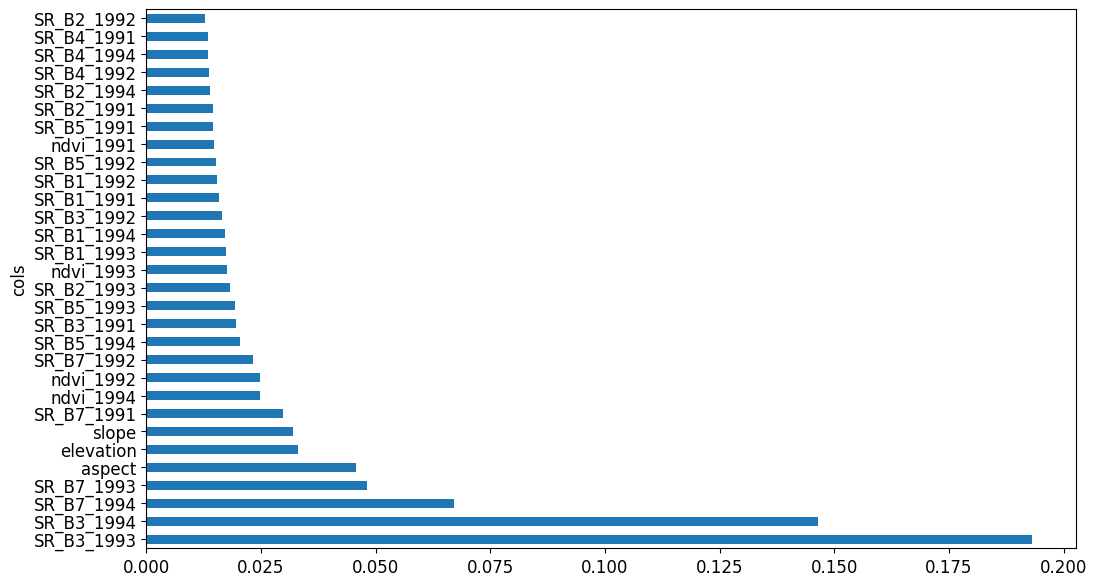

In [216]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])